In [1]:
import pickle

import flax
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from flax.training import checkpoints

from temporal_explanations_4_rl.agent_networks import (
    AtariDqnFlaxNetwork,
    AtariRainbowFlaxNetwork,
)
from temporal_explanations_4_rl.dataset import load_atari_obs, load_discrete_actions
from temporal_explanations_4_rl.explain import (
    generate_atari_grad_cam_explanation,
    generate_atari_perturbation_saliency_explanation,
)

In [2]:
envs = ["Breakout", "SpaceInvaders", "Seaquest"]

dqn_networks_def = [
    AtariDqnFlaxNetwork(gym.make(f"ALE/{env}-v5").action_space.n) for env in envs
]
rainbow_networks_def = [
    AtariRainbowFlaxNetwork(
        gym.make(f"ALE/{env}-v5").action_space.n,
        num_atoms=51,
        supports=np.linspace(-10, 10, 51),
    )
    for env in envs
]
dqn_networks_params = []
rainbow_networks_params = []
for env in envs:
    with open(f"../models/dopamine/jax/dqn_adam_mse/{env}/1/ckpt.199", "rb") as file:
        dqn_networks_params.append(
            flax.core.FrozenDict(
                {
                    "params": checkpoints.convert_pre_linen(
                        pickle.load(file)["online_params"]
                    )
                }
            )
        )
    with open(f"../models/dopamine/jax/rainbow/{env}/1/ckpt.199", "rb") as file:
        rainbow_networks_params.append(
            flax.core.FrozenDict(
                {
                    "params": checkpoints.convert_pre_linen(
                        pickle.load(file)["online_params"]
                    )
                }
            )
        )

obs_i = 350
agent_obs = [
    load_atari_obs(f"../datasets/dqn_adam_mse-{env}/trajectories", num_files=1)[obs_i]
    for env in envs
]
actions = [
    load_discrete_actions(f"../datasets/dqn_adam_mse-{env}/trajectories", num_files=1)[
        obs_i
    ]
    for env in envs
]

A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]


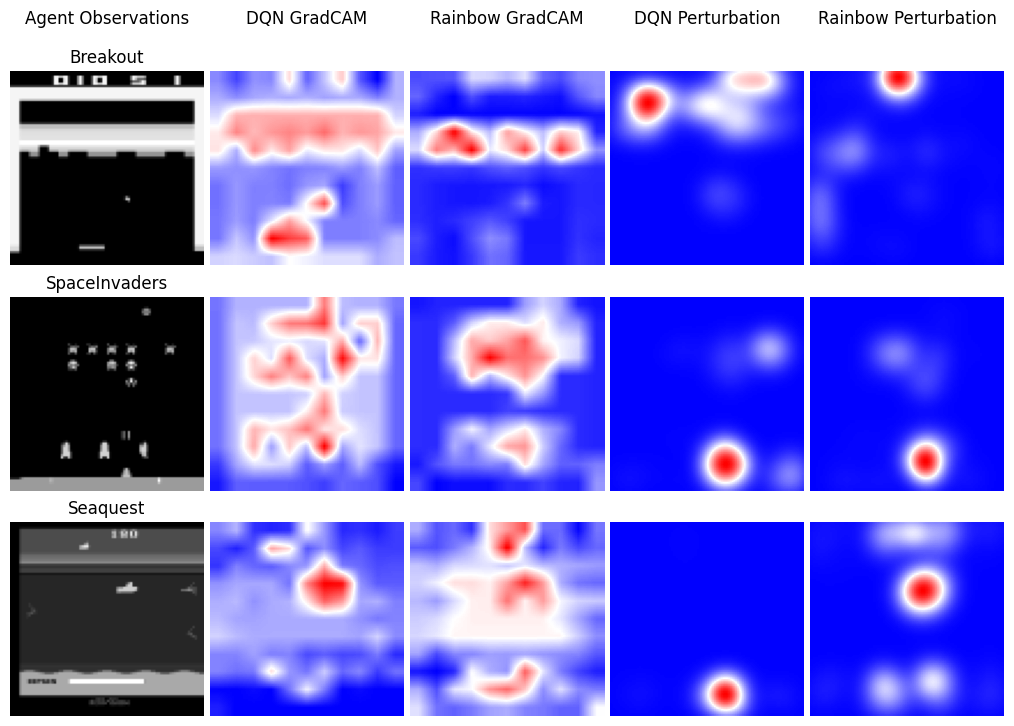

In [3]:
# Environment comparison for perturbation and GradCAM saliency map
fig = plt.figure(constrained_layout=True, figsize=(10, 8))
# fig.suptitle("Comparison of Perturbation and GradCAM")
subfigs = fig.subfigures(ncols=5)

subfigs[0].suptitle("Agent Observations")
axs = subfigs[0].subplots(nrows=len(envs))
for ax, env, obs in zip(axs, envs, agent_obs):
    ax.set_title(env)
    ax.imshow(obs[..., -1], cmap="gray")
    ax.axis("off")

subfigs[1].suptitle("DQN GradCAM")
axs = subfigs[1].subplots(nrows=len(envs))
for i, (ax, obs, action) in enumerate(zip(axs, agent_obs, actions)):
    ax.imshow(
        generate_atari_grad_cam_explanation(
            dqn_networks_def[i],
            dqn_networks_params[i],
            obs,
            action,
            feature_method=f"feature_1",
            q_network_method=f"q_network_1",
        )[0],
        cmap="bwr",
    )
    ax.axis("off")

subfigs[2].suptitle("Rainbow GradCAM")
axs = subfigs[2].subplots(nrows=len(envs))
for i, (ax, obs, action) in enumerate(zip(axs, agent_obs, actions)):
    ax.imshow(
        generate_atari_grad_cam_explanation(
            rainbow_networks_def[i],
            rainbow_networks_params[i],
            obs,
            action,
            feature_method=f"feature_1",
            q_network_method=f"q_network_1",
        )[0],
        cmap="bwr",
    )
    ax.axis("off")

subfigs[3].suptitle("DQN Perturbation")
axs = subfigs[3].subplots(nrows=len(envs))
for i, (ax, obs, action) in enumerate(zip(axs, agent_obs, actions)):
    ax.imshow(
        generate_atari_perturbation_saliency_explanation(
            obs, dqn_networks_def[i], dqn_networks_params[i]
        )[0],
        cmap="bwr",
    )
    ax.axis("off")

subfigs[4].suptitle("Rainbow Perturbation")
axs = subfigs[4].subplots(nrows=len(envs))
for i, (ax, obs) in enumerate(zip(axs, agent_obs)):
    ax.imshow(
        generate_atari_perturbation_saliency_explanation(
            obs,
            rainbow_networks_def[i],
            rainbow_networks_params[i],
        )[0],
        cmap="bwr",
    )
    ax.axis("off")

plt.tight_layout()
plt.savefig("figs/saliency-maps/comparing-perturbation-gradcam.pdf")
plt.savefig("figs/saliency-maps/comparing-perturbation-gradcam.png")

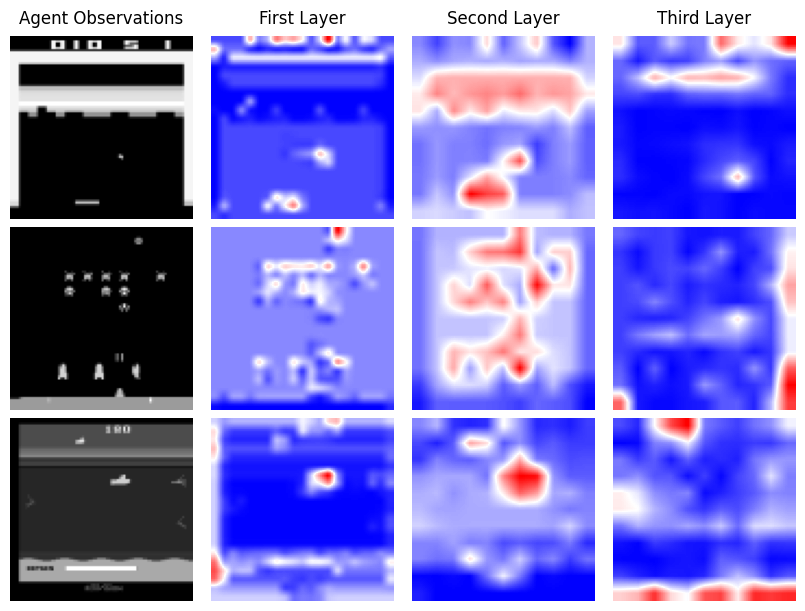

In [7]:
# GradCAM layer comparison
fig = plt.figure(constrained_layout=True, figsize=(8, 6))
# fig.suptitle("GradCAM Layer Comparison for DQN")
subfigs = fig.subfigures(ncols=4)

subfigs[0].suptitle("Agent Observations")
axs = subfigs[0].subplots(nrows=len(envs))
for ax, obs in zip(axs, agent_obs):
    ax.imshow(obs[..., -1], cmap="gray")
    ax.axis("off")

for layer, title in zip(range(3), ["First", "Second", "Third"]):
    subfigs[layer + 1].suptitle(f"{title} Layer")
    axs = subfigs[layer + 1].subplots(nrows=len(envs))

    for i, (ax, obs, action) in enumerate(zip(axs, agent_obs, actions)):
        ax.imshow(
            generate_atari_grad_cam_explanation(
                dqn_networks_def[i],
                dqn_networks_params[i],
                obs,
                action,
                feature_method=f"feature_{layer}",
                q_network_method=f"q_network_{layer}",
            )[0],
            cmap="bwr",
        )
        ax.axis("off")

# plt.tight_layout()
plt.savefig("figs/saliency-maps/gradcam-dqn-layer-comparison.png")
plt.savefig("figs/saliency-maps/gradcam-dqn-layer-comparison.pdf")

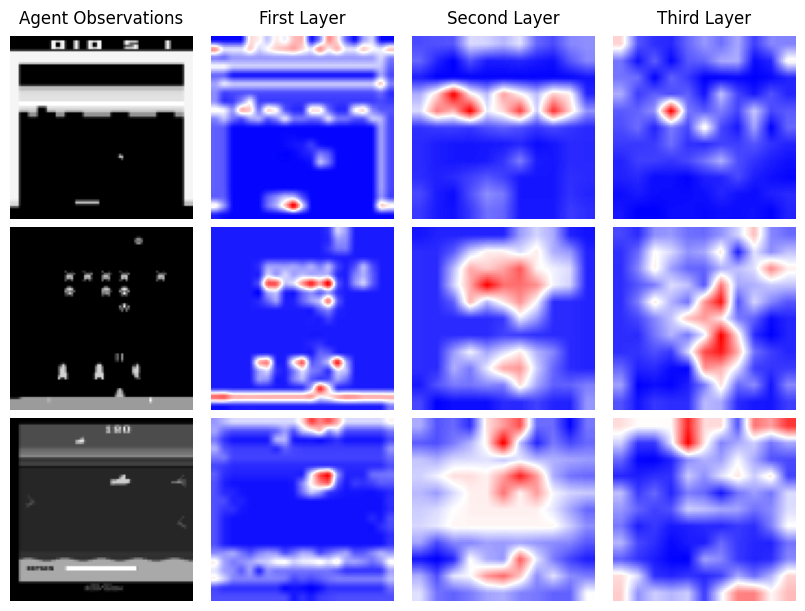

In [8]:
# GradCAM layer comparison
fig = plt.figure(constrained_layout=True, figsize=(8, 6))
# fig.suptitle("GradCAM Layer Comparison for Rainbow")
subfigs = fig.subfigures(ncols=4)

subfigs[0].suptitle("Agent Observations")
axs = subfigs[0].subplots(nrows=len(envs))
for ax, obs in zip(axs, agent_obs):
    ax.imshow(obs[..., -1], cmap="gray")
    ax.axis("off")

for layer, title in zip(range(3), ["First", "Second", "Third"]):
    subfigs[layer + 1].suptitle(f"{title} Layer")
    axs = subfigs[layer + 1].subplots(nrows=len(envs))

    for i, (ax, obs, action) in enumerate(zip(axs, agent_obs, actions)):
        ax.imshow(
            generate_atari_grad_cam_explanation(
                rainbow_networks_def[i],
                rainbow_networks_params[i],
                obs,
                action,
                feature_method=f"feature_{layer}",
                q_network_method=f"q_network_{layer}",
            )[0],
            cmap="bwr",
        )
        ax.axis("off")

# plt.tight_layout()
plt.savefig("figs/saliency-maps/gradcam-rainbow-layer-comparison.png")
plt.savefig("figs/saliency-maps/gradcam-rainbow-layer-comparison.pdf")

Spacing=2
Spacing=4
Spacing=5
Spacing=8


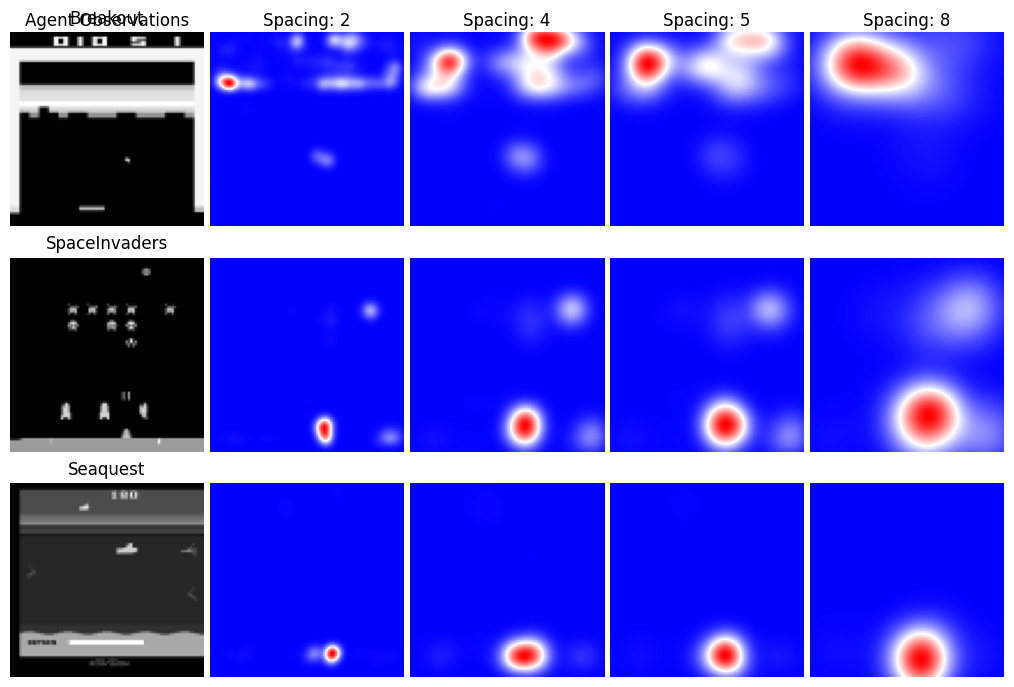

In [6]:
# Environment comparison for perturbation and GradCAM saliency map
fig = plt.figure(constrained_layout=True, figsize=(10, 7))
# fig.suptitle("Comparison of Perturbation spacing hyperparameter")
subfigs = fig.subfigures(ncols=5)

subfigs[0].suptitle("Agent Observations")
axs = subfigs[0].subplots(nrows=len(envs))
for ax, env, obs in zip(axs, envs, agent_obs):
    ax.set_title(env)
    ax.imshow(obs[..., -1], cmap="gray")
    ax.axis("off")

for j, spacing in enumerate([2, 4, 5, 8]):
    print(f"Spacing={spacing}")
    subfigs[j + 1].suptitle(f"Spacing: {spacing}")
    axs = subfigs[j + 1].subplots(nrows=len(envs))
    for i, (ax, obs) in enumerate(zip(axs, agent_obs)):
        ax.imshow(
            generate_atari_perturbation_saliency_explanation(
                obs,
                dqn_networks_def[i],
                dqn_networks_params[i],
                perturbation_spacing=spacing,
            )[0],
            cmap="bwr",
        )
        ax.axis("off")

plt.tight_layout()
plt.savefig("figs/saliency-maps/perturbation-spacing-hyperparameter.png")
plt.savefig("figs/saliency-maps/perturbation-spacing-hyperparameter.pdf")
